# Power Spectrum - P(k)

Here I try to run `nbodykit` to compute the cluster power spectrum. 

Following this notebook:\
https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html \
https://github.com/bccp/nbodykit-cookbook/blob/master/recipes/fftpower.ipynb

## Installing Nobdykit

If you don't have the package it might take some time to install it. In the NERSC computer I had to create a special environement for nbodykit.

```
conda create --name nbodykit-env python=3.7 # or use python=2 for python 2.7*
source activate nbodykit-env
conda install -c bccp nbodykit
```

Then, to add to your jupyter notebook environement.
```
pip install ipykernel
python -m ipykernel install --user --name=nbodykit-env
```

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# !pip install nbodykit

In [4]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [5]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [6]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [7]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [8]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$'}


## Adding the Catalog

In [9]:
from util import load_data, apply_bin_cut
print('Load Data')
rm_all, ran_all = load_data()

Load Data


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/project/projectdirs/des/www/y3_cats/y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_12_3_19.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
ran = Table(ran_all[['ra','dec','ztrue', 'weight', 'avg_lambdaout']])
ran.rename_column('ztrue', 'z')


In [8]:
# from fileLoc import FileLocs

# floc = FileLocs(machine='nersc')
# print('halo file name: %s'%floc.mock_fname)

# mock = Table(getdata(floc.mock_fname))

In [1]:
ran_all = Table(getdata('../correlationFunction/tmp_random.fits'))
rm_all = Table(getdata('../correlationFunction/tmp_data.fits'))

NameError: name 'Table' is not defined

In [10]:
# data = Table(mock[['RA','DEC','redshift']])
# data.rename_columns(['RA','DEC','redshift'], ['ra','dec','z'])
# data['ra'] = np.where(data['ra']<=0., 180-data['ra'], data['ra'])
# select_good = (data['z']>=0.2) & (data['z']<=0.65)
# select_good = select_good & ((data['z'] < 0.33)|(data['z'] > 0.37))
# data = data[select_good]

data = rm_all[['ra','dec','z_lambda']]
data.rename_column('z_lambda','z')
select_good = (data['z']>=0.2) & (data['z']<=0.65)
data = data[select_good]

# data = data.to_pandas()


randoms = ran_all[['ra','dec','ztrue','weight']]
randoms.rename_column('ztrue','z')

# take x 10 to start
# apply redshift cut 
select_good = (randoms['z']>=0.2) & (randoms['z']<=0.65)
# select_good = select_good & ((randoms['z'] < 0.33)|(randoms['z'] > 0.37))

Nran = int(len(data)*40)
indices = np.random.randint(np.count_nonzero(select_good), size=Nran)
randoms = randoms[select_good][indices]

# randoms = randoms.to_pandas()

In [11]:
import os 
clobber=True
if clobber | (not os.path.isfile('tmp_random.fits')):
    randoms.write('tmp_random.fits',overwrite=True)
    data.write('tmp_data.fits',overwrite=True)


In [12]:
# NOTE: change this path if you downloaded the data somewhere else!
# data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
# randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')
randoms_path = 'tmp_random.fits'
data_path = 'tmp_data.fits'

# initialize the FITS catalog objects for data and randoms
data = FITSCatalog(data_path)
randoms = FITSCatalog(randoms_path)

## Estimating n(z)

A nice paper to understand the importance of the volume element in surveys:
https://arxiv.org/pdf/astro-ph/9304022.pdf

In [13]:
# plt.hist(randoms['z'])
# plt.hist(data['z'])

In [14]:
# # combine the data and randoms into a single catalog
# fkp = FKPCatalog(data, randoms, )

## Start Tutorial

In [15]:
# specify our cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

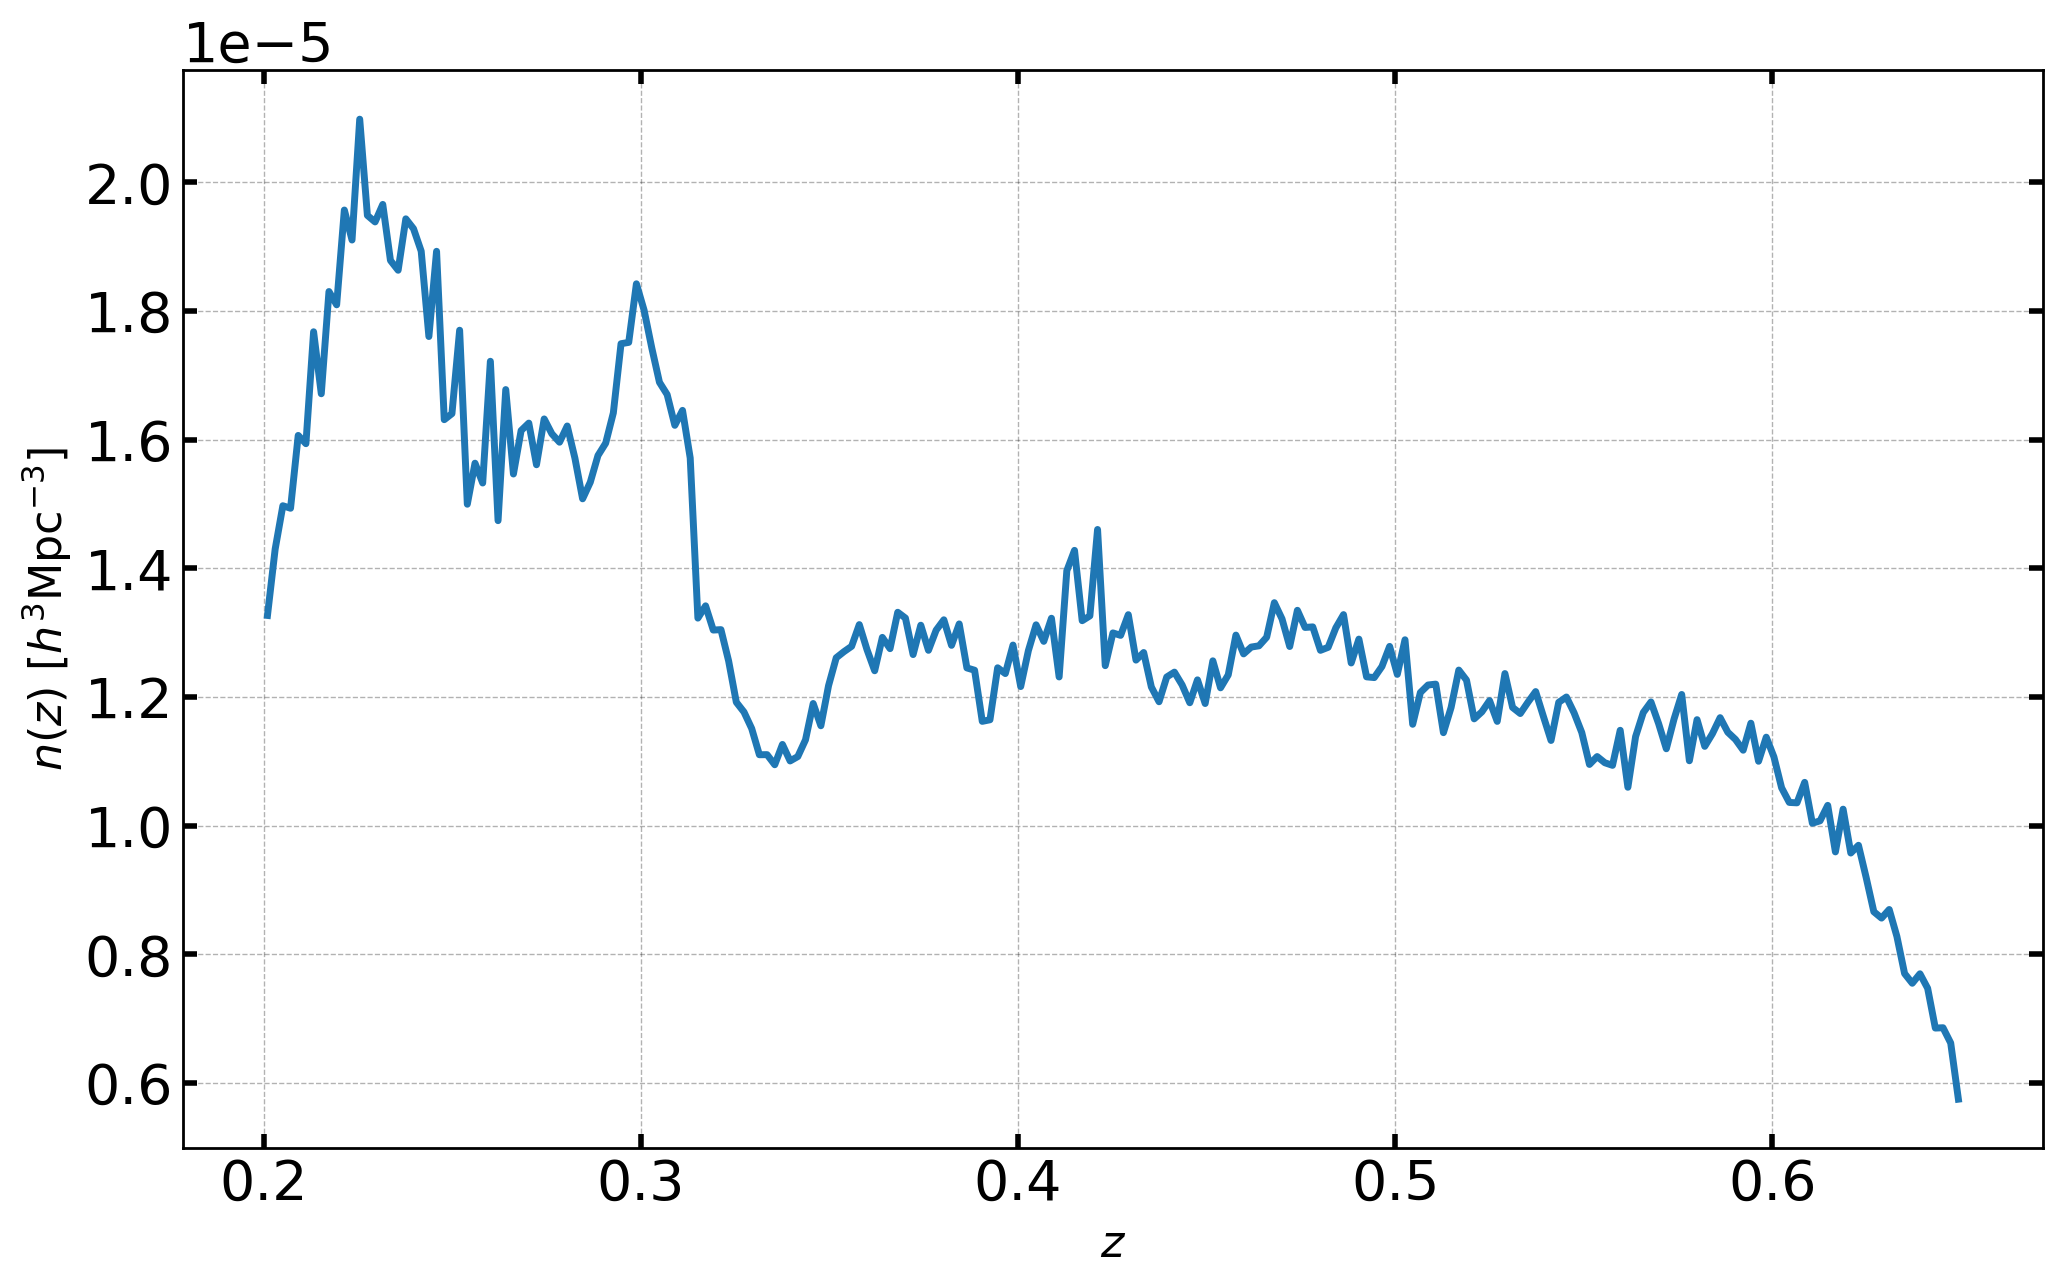

In [16]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')

# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# plot
plt.plot(zhist.bin_centers, alpha*zhist.nbar)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

In [17]:
# add the n(z) columns to the FKPCatalog
randoms['NZ'] = nofz(randoms['z'])
data['NZ'] = nofz(data['z'])

In [18]:
# initialize the FKP source
fkp = FKPCatalog(data, randoms)

# print out the columns
print("columns in FKPCatalog = ", fkp.columns)

columns in FKPCatalog =  ['data/FKPWeight', 'data/NZ', 'data/Position', 'data/Selection', 'data/Value', 'data/Weight', 'data/dec', 'data/ra', 'data/z', 'randoms/FKPWeight', 'randoms/NZ', 'randoms/Position', 'randoms/Selection', 'randoms/Value', 'randoms/Weight', 'randoms/dec', 'randoms/ra', 'randoms/weight', 'randoms/z']


## Adding FKP Weights

Here, we add a column ``FKPWeight`` that gives the appropriate FKP weight for each catalog. The FKP weights are given by:

$$
w_\mathrm{FKP} = \frac{1}{1 + n(z)P_0}.
$$

Here, we use a value of $P_0 = 2 \times 10^4 \ h^{-3} \mathrm{Mpc}^3$.

I took this value from: https://arxiv.org/pdf/1608.05446.pdf

In [19]:
fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 2e4)

In [20]:
data['FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
randoms['FKPWeight'] =1.0 / (1 + fkp['randoms/NZ'] * 2e4)

## Computing the Multipoles
To compute the multipoles, first we convert our ``FKPCatalog`` to a mesh object, specifying the number of mesh cells per side, as well as the names of the $n(z)$ and weight columns. 

If a Cartesian box size is not specified by the user, 
the size will be computed from the maximum extent of the ``Position`` column automatically.

In [21]:
# density = mesh.preview(Nmesh=64, axes=(0,1))
# plt.imshow(density)

In [22]:
mesh = fkp.to_mesh(Nmesh=512+256, nbar='NZ', fkp_weight='FKPWeight', window='tsc')

In [25]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0], dk=0.001, kmin=0.005)
# r00 = FFTPower(mesh, mode='1d', los=[1,0,0], kmin=0.005, kmax=1000, dk=0.05)


/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


In [26]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0]
dk = 0.001
kmin = 0.005
kmax = None
Nmesh = [512 512 512]
BoxSize = [1832. 2722. 1693.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [ 752.67442256  219.7993608  -686.5748235 ]
mesh.resampler = tsc
mesh.interlaced = False
alpha = 0.025
data.norm = 1.7291925437157913
randoms.norm = 1.7279062919419346
shotnoise = 83025.18780491207
data.N = 217986
data.W = 217986.0
data.W2 = 174542.88062249136
data.num_per_cell = 0.0013004457996971261
randoms.N = 8719440
randoms.W = 8719440.0
randoms.W2 = 6983468.472902042
randoms.num_per_cell = 0.05203089470343323
data.ext = 1
randoms.ext = 1


## DES Y3

In [29]:
P = r.poles['power_0'].real
P = P - r.poles.attrs['shotnoise']


In [178]:
kvec = np.logspace(-3, np.log10(5.), 50)
isnan = np.isnan(np.log(P))
# isnan |= P<1e2
k, pk = r.poles['k'][~isnan], P[~isnan]
log_k, log_pk = np.log(k), np.log(pk)

from scipy.ndimage import uniform_filter1d
# rolling average
y = uniform_filter1d(pk, size=int(k.size/50))
y2 = uniform_filter1d(pk, size=int(k.size/7))
ix = np.where(k>0.22)[0]
y[ix] = y2[ix]

# fist points do with the average
# ix = np.where(k<0.3)[0]
log_pk = np.log(y)



/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [179]:
from scipy.interpolate import interp1d
pk_interp = interp1d(log_k, log_pk, bounds_error=False, kind='cubic')

pk_vec = np.exp(pk_interp(np.log(kvec)))
isnan = ~np.isnan(pk_vec)
pk_vec = pk_vec[isnan]
kvec = kvec[isnan]


In [218]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

# s, xi0 = hankl.P2xi(kvec, pk_vec, l=0)
s, xi0 = hankl.P2xi(kvec, pk_vec, l=0)

Using hankel v1.1.0


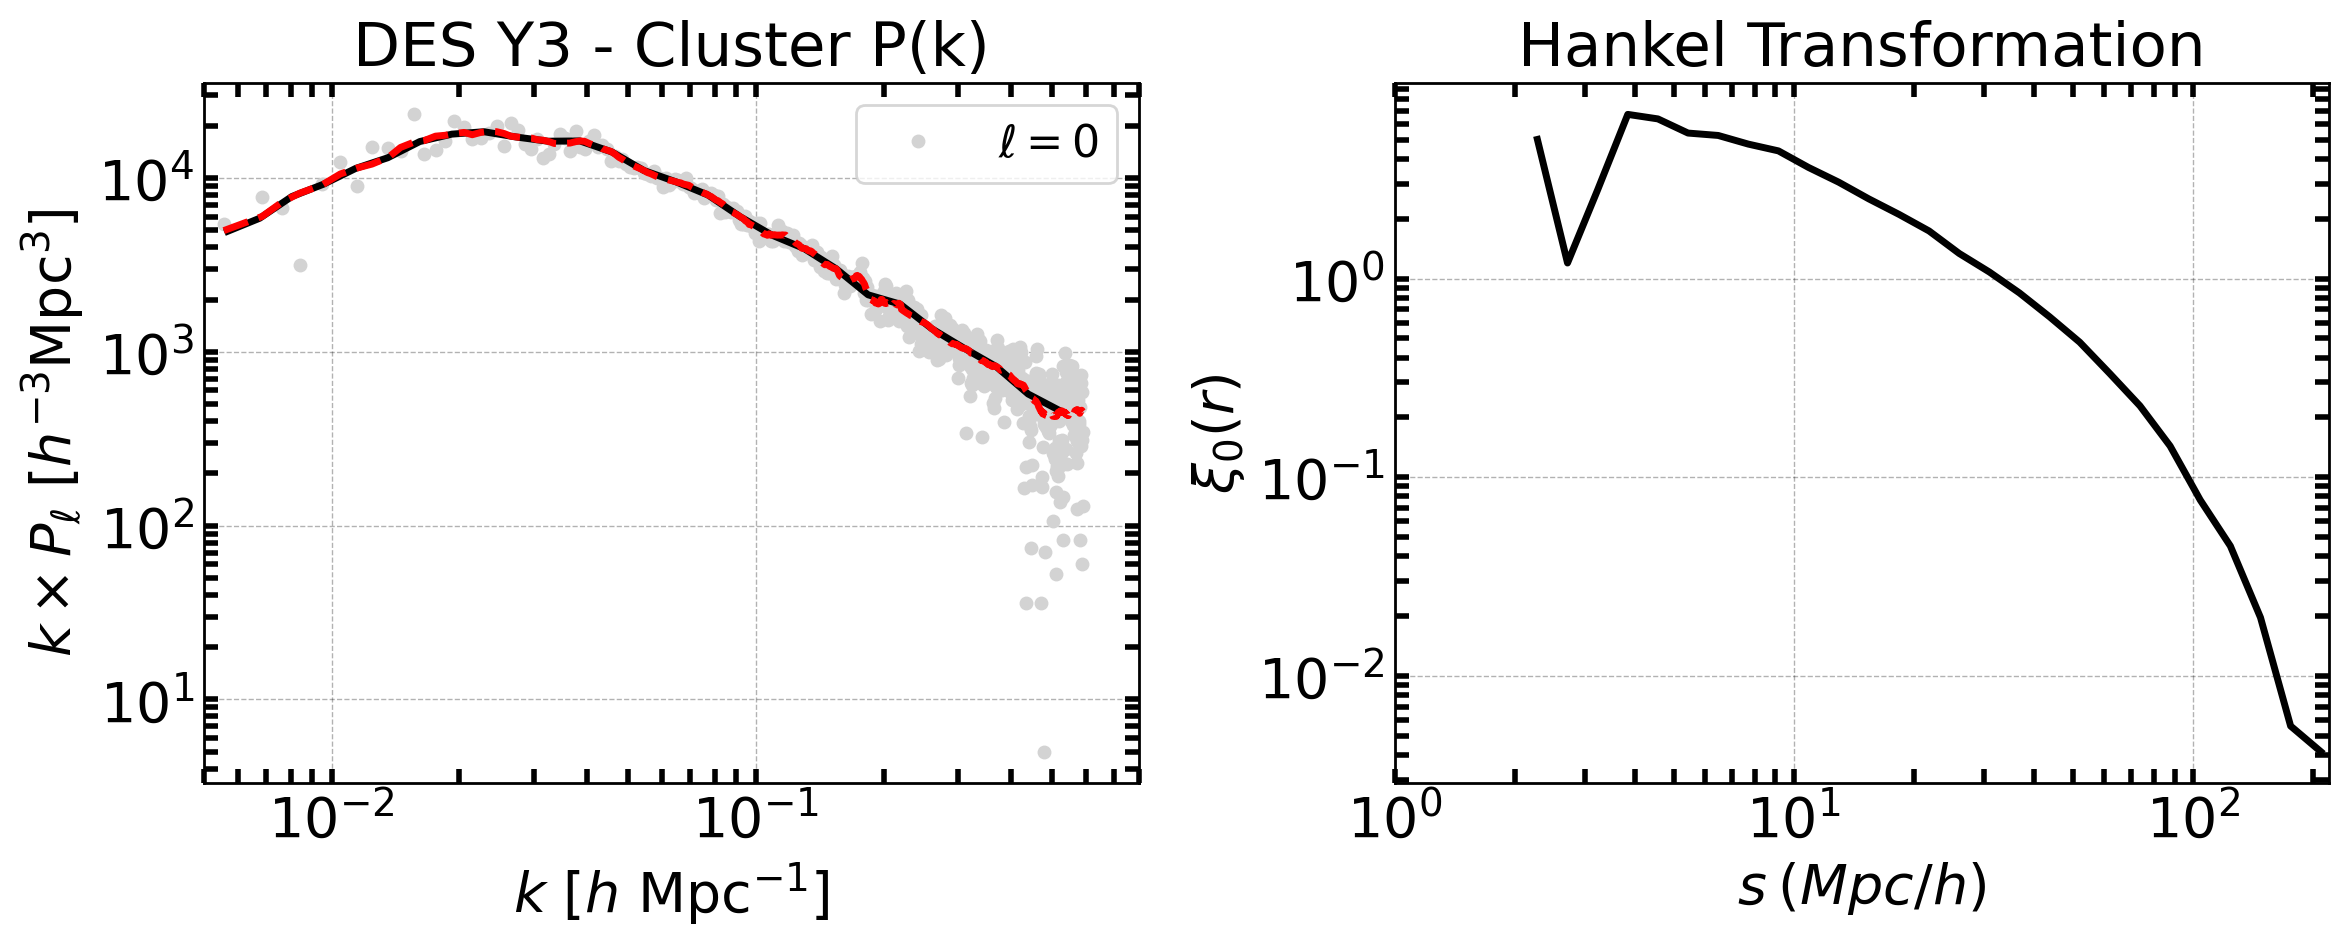

In [249]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
poles = r.poles
plt.loglog()
for ell in [0]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], poles['k']*P, '.', color='lightgray', label=label)

    
plt.plot(kvec, pk_vec*kvec, 'k')
plt.plot(k, k*y, 'r--')
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.005, 0.8)
plt.title('DES Y3 - Cluster P(k)')

plt.subplot(1,2,2)
# plt.xscale('log')
plt.loglog()
plt.plot(s, xi0, 'k')
# plt.ylim(-60,30)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$\xi_{0}(r)$')
# plt.legend()
plt.title('Hankel Transformation')
plt.xlim(1.,220)
plt.subplots_adjust(wspace=0.25)
fig.tight_layout()
plt.savefig('pk_desy3_lgt5.png', transparent=False, facecolor='w', dpi=150)

In [246]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/camb


In [247]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.2, 0.65], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)


Note: redshifts have been re-sorted (earliest first)


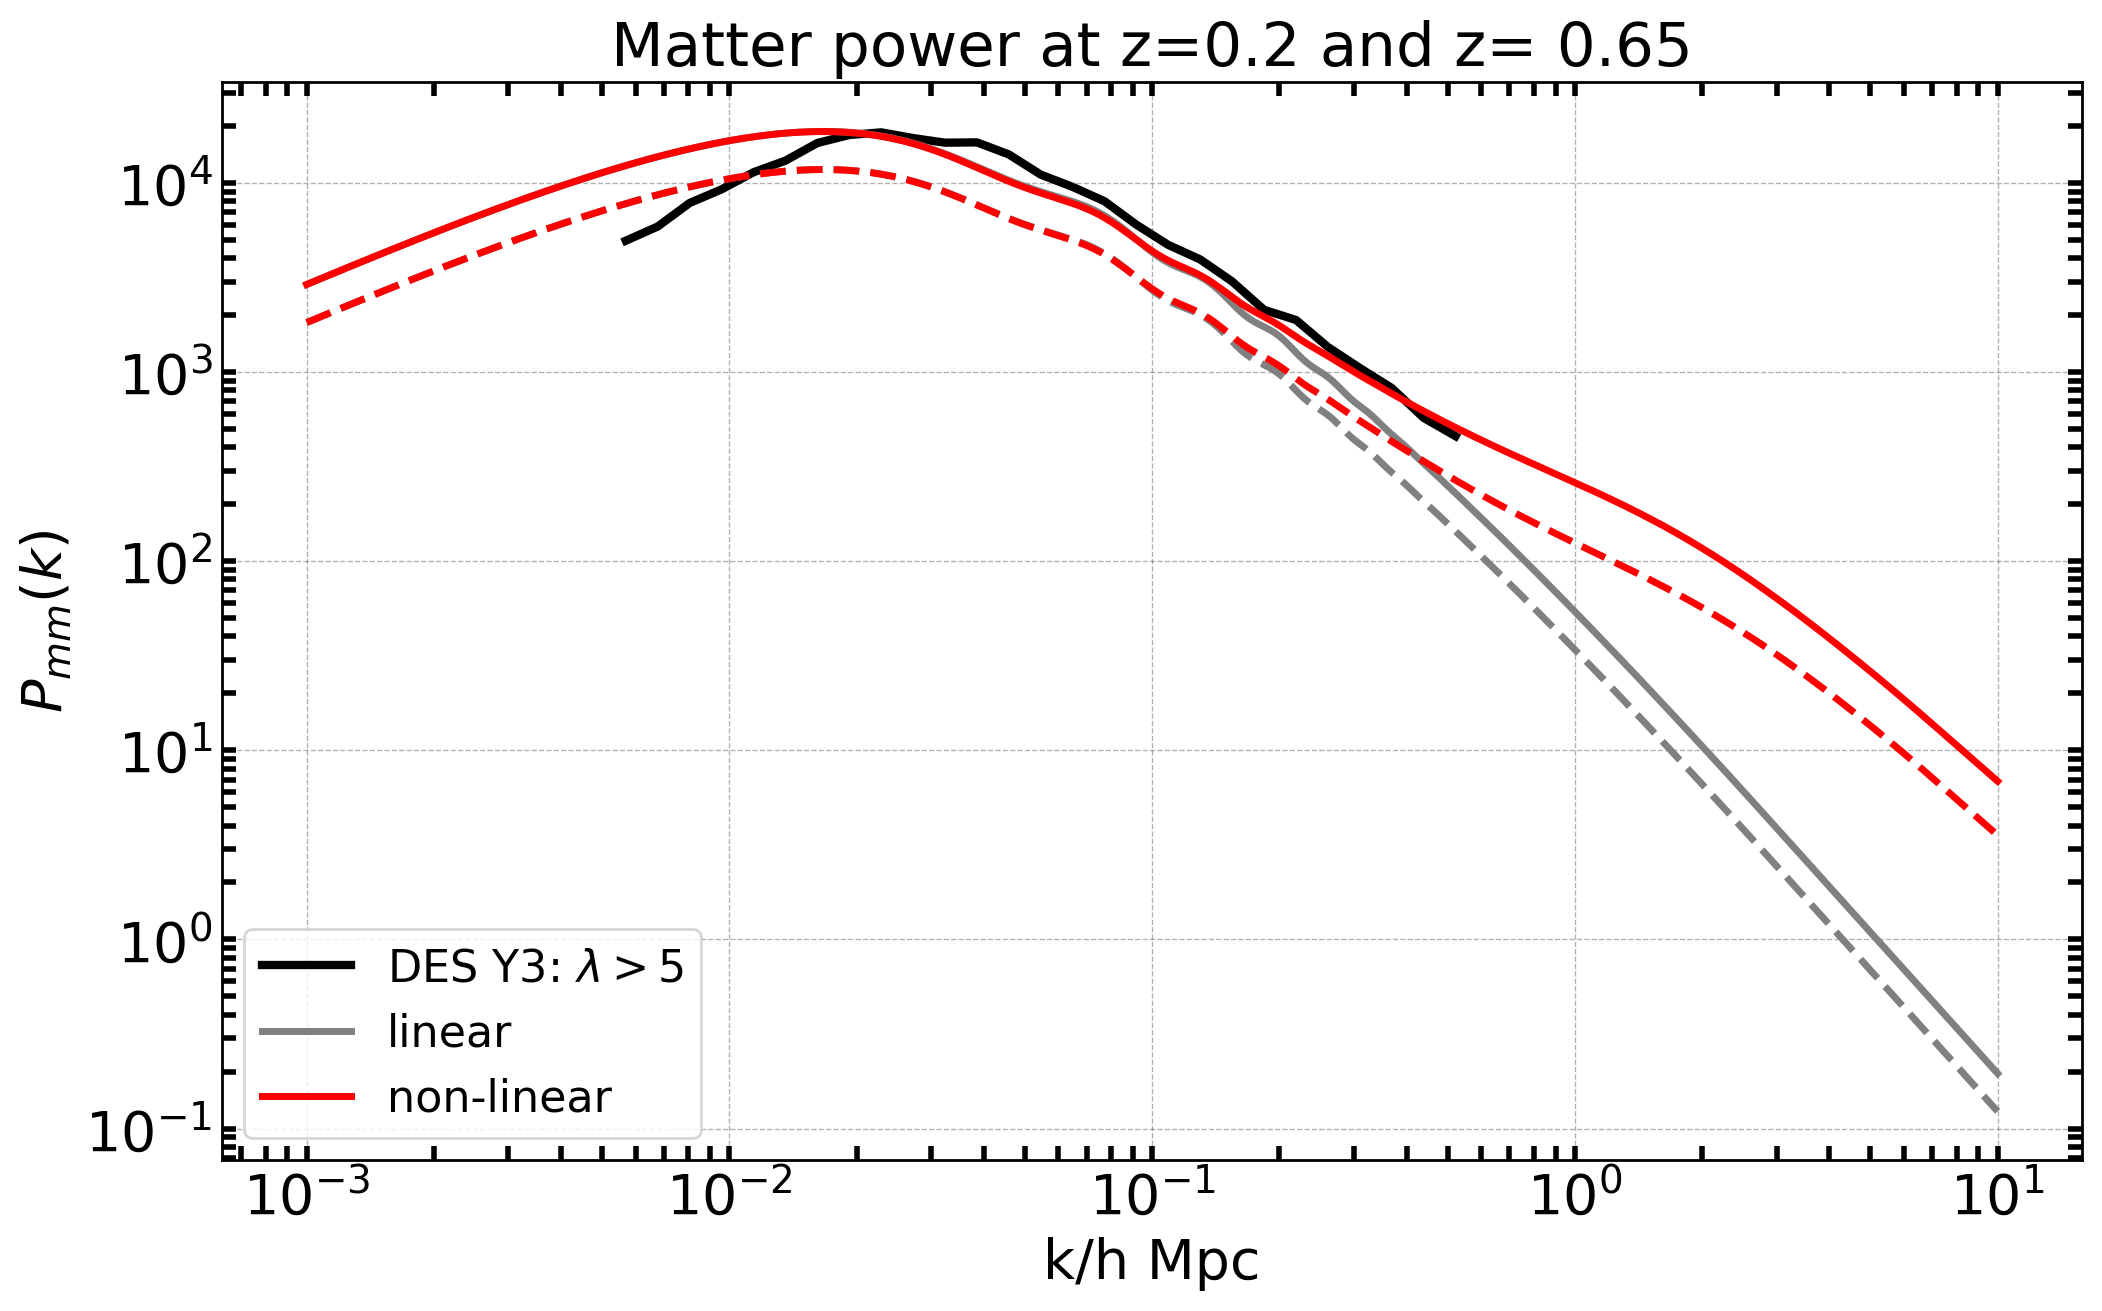

In [253]:
b=1.

plt.plot(kvec, pk_vec*kvec, 'k', lw=3)
for i, (redshift, line) in enumerate(zip(z_lin,['-','--'])):
    plt.loglog(kh_lin, b**2*pk_lin[i,:], color='gray', ls = line)
    plt.loglog(kh_nonlin, b**2*pk_nonlin[i,:], color='r', ls = line)

plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['DES Y3: $\lambda>5$','linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z_lin));

plt.savefig('pk_desy3_lgt5_camb.png', transparent=False, facecolor='w', dpi=150)